In [ ]:
!pip install pandas seaborn scikit-learn

# МЛ Практика 3: Задача классификации

## Цель занятия
- EDA для номинальных переменных
- Стандартизация и encoder
- Понять задачу классификации
- Построить базовые модели для задачи классификации
- Разобрать метрики качества

## Задача классификации

Задача классификации - одна из задач машинного обучения, цель которой, отнесение одно из объектов к определенному классу, например:
- `болен, здоров`
- `кошка, собака, слон`
- `спам, не спам`

По видам разделяю несколько типов задач классификации
- `бинарная` ```[0, 1]```
- `мультиклассовая` ```[холодно, жарко, тепло, прохладно, ...]```

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [ ]:
df['Sleep Disorder'] = df['Sleep Disorder'].astype('category')
df['Gender'] = df['Gender'].astype('category')
df['Occupation'] = df['Occupation'].astype('category')
df['BMI Category'] = df['BMI Category'].astype('category')

### Дополнение к EDA с анализом мультиклассовых перменных

Проверим связи между quality и вин с высоким и низкии содержанием алкоголя

In [ ]:
# для начала бинаризируем Sleep_Duration
df['Sleep_Duration_level'] = df['Sleep Duration'].apply(
    lambda x: 'high' if x > df['Sleep Duration'].median() else 'low'
)

In [ ]:
df.Sleep_Duration_level

,Sleep_Duration_level
0,low
1,low
2,low
3,low
4,low
...,...
369,high
370,high
371,high
372,high


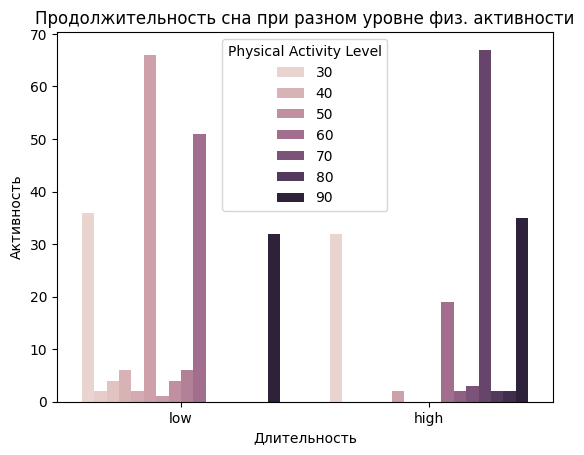

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# визуализируем различия alcohol_level и qualuty
sns.countplot(data=df, x='Sleep_Duration_level', hue='Physical Activity Level')
plt.title('Продолжительность сна при разном уровне физ. активности')
plt.xlabel('Длительность')
plt.ylabel('Активность')
plt.show()


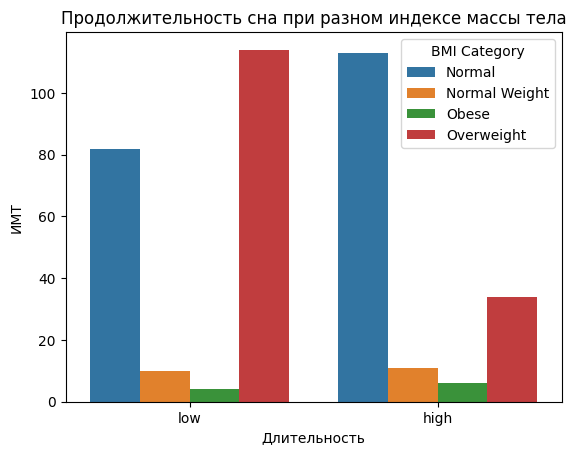

In [ ]:

sns.countplot(data=df, x='Sleep_Duration_level', hue='BMI Category')
plt.title('Продолжительность сна при разном индексе массы тела')
plt.xlabel('Длительность')
plt.ylabel('ИМТ')
plt.show()


Видим, что в белых винах, больше качественных вин, нежели в красном.
Но важно учитывать, что баланс классов неравномерен.

In [ ]:
table = pd.crosstab(df['Sleep_Duration_level'], df['BMI Category'])
table

BMI Category,Normal,Normal Weight,Obese,Overweight
Sleep_Duration_level,,,,
high,113,11,6,34
low,82,10,4,114


Проанализируем зависимость двух категориальных переменных численным методом

χ² (хи-квадрат) — проверка наличия зависимости

Тест (хи-квадрат) отвечает на вопрос, `Есть ли вообще связь между переменными, или это просто случайность?`

Интерпретация:

`p < 0.05` → зависимость есть (значимая)

`p ≥ 0.05` → зависимость не доказана

In [ ]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(table)
print(f"χ² = {chi2:.2f}")
print(f"p-value = {p}")


χ² = 43.62
p-value = 1.816350564007061e-09


Это p-значение очень мало, что эквивалентно (0.000000001816...)
Это означает, что наблюдаемые различия в данных являются статистически значимыми и, вероятно, не вызваны случайностью.


### Нормализация числовых признаков

Во многих алгоритмах машинного обучения (например, kNN, SVM, кластеризация)
результаты зависят от **расстояния между точками** в пространстве признаков.

Если один признак имеет **большие значения**, а другой — **маленькие**,  
то расстояние будет зависеть почти только от **крупных чисел**,
а маленькие признаки почти не влияют на результат.


### Методы нормализации числовых признаков

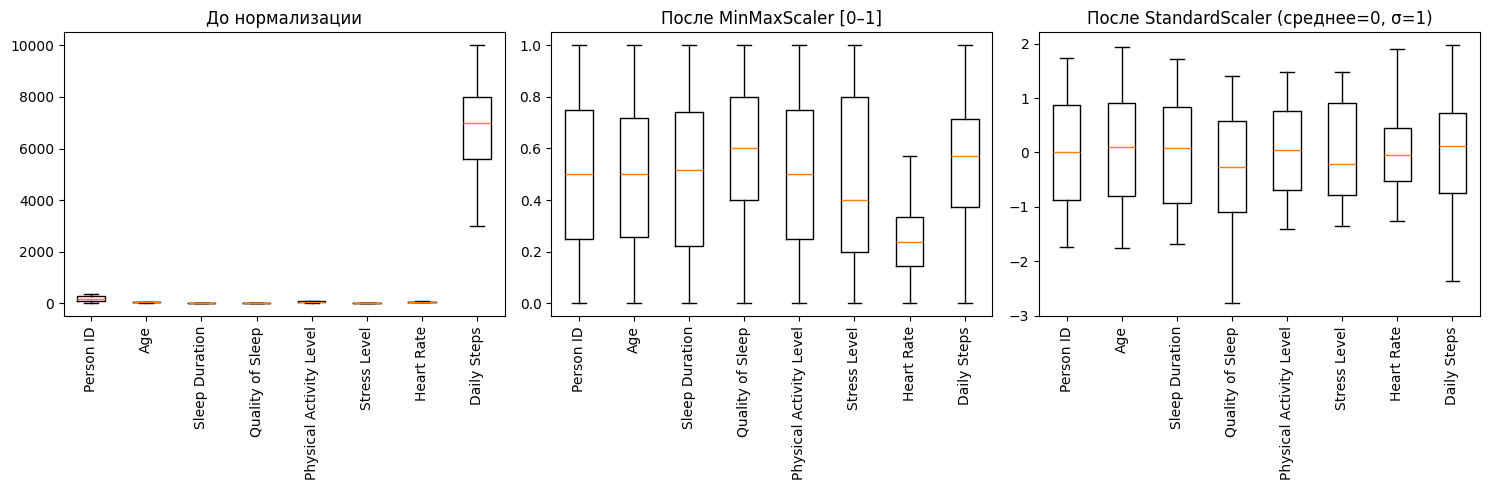

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Берем все числовые признаки
num_df = df.select_dtypes(include=[int, float]).copy()

# --- Применяем два метода нормализации ---
minmax_scaled = pd.DataFrame(MinMaxScaler().fit_transform(num_df), columns=num_df.columns)
std_scaled = pd.DataFrame(StandardScaler().fit_transform(num_df), columns=num_df.columns)

# --- Визуализация ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].boxplot(num_df.values, showfliers=False)
axes[0].set_title("До нормализации")
axes[0].set_xticks(range(1, len(num_df.columns)+1))
axes[0].set_xticklabels(num_df.columns, rotation=90)

axes[1].boxplot(minmax_scaled.values, showfliers=False)
axes[1].set_title("После MinMaxScaler [0–1]")
axes[1].set_xticks(range(1, len(num_df.columns)+1))
axes[1].set_xticklabels(num_df.columns, rotation=90)

axes[2].boxplot(std_scaled.values, showfliers=False)
axes[2].set_title("После StandardScaler (среднее=0, σ=1)")
axes[2].set_xticks(range(1, len(num_df.columns)+1))
axes[2].set_xticklabels(num_df.columns, rotation=90)

plt.tight_layout()
plt.show()


### Задача классификации

In [ ]:
y = df['BMI Category']
X = df.drop(columns=['BMI Category', 'Sleep Duration']) # есть переменная Sleep Duration level
X.Sleep_Duration_level = X.Sleep_Duration_level.astype('category')

In [ ]:
X

,Person ID,Gender,Age,Occupation,Quality of Sleep,Physical Activity Level,Stress Level,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,stress_level,activity_level,sleep_quality_level,sleep_duration_level,Sleep Duration_level,Sleep_Duration_level
0,1,Male,27,Software Engineer,6,42,6,126/83,77,4200,NaN,high,low,poor,low,low,low
1,2,Male,28,Doctor,6,60,8,125/80,75,10000,NaN,high,low,poor,low,low,low
2,3,Male,28,Doctor,6,60,8,125/80,75,10000,NaN,high,low,poor,low,low,low
3,4,Male,28,Sales Representative,4,30,8,140/90,85,3000,Sleep Apnea,high,low,poor,low,low,low
4,5,Male,28,Sales Representative,4,30,8,140/90,85,3000,Sleep Apnea,high,low,poor,low,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,9,75,3,140/95,68,7000,Sleep Apnea,low,high,good,high,high,high
370,371,Female,59,Nurse,9,75,3,140/95,68,7000,Sleep Apnea,low,high,good,high,high,high
371,372,Female,59,Nurse,9,75,3,140/95,68,7000,Sleep Apnea,low,high,good,high,high,high
372,373,Female,59,Nurse,9,75,3,140/95,68,7000,Sleep Apnea,low,high,good,high,high,high


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd

# --- Подготовка данных ---

# --- Определяем типы признаков ---
# Числовые признаки
numeric_features = ['Age', 'Quality of Sleep', 'Heart Rate', 'Daily Steps',
                   'Systolic_BP', 'Diastolic_BP']

# Категориальные признаки для OneHotEncoder
categorical_features = ['Gender', 'Occupation', 'Sleep Disorder',
                       'Physical Activity Level', 'Sleep_Duration_level']

# Удаляем Person ID, так как это идентификатор, а не признак


# --- Создаем preprocessing pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# --- Применяем преобразования ---
X_processed = preprocessor.fit_transform(X)

# --- Создаем DataFrame с правильными названиями колонок ---
# Получаем названия колонок после OneHotEncoder
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Объединяем все названия колонок
feature_names = numeric_features + list(cat_feature_names)

# Создаем итоговый DataFrame
X = pd.DataFrame(X_processed, columns=feature_names)

X.head()

,Age,Quality of Sleep,Heart Rate,Daily Steps,Systolic_BP,Diastolic_BP,Gender_Male,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,...,Physical Activity Level_50,Physical Activity Level_55,Physical Activity Level_60,Physical Activity Level_65,Physical Activity Level_70,Physical Activity Level_75,Physical Activity Level_80,Physical Activity Level_85,Physical Activity Level_90,Sleep_Duration_level_low
0,-1.753096,-1.098280,1.654719,-1.619584,-0.330002,-0.268102,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.637643,-1.098280,1.170474,1.970077,-0.459239,-0.755640,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.637643,-1.098280,1.170474,1.970077,-0.459239,-0.755640,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.637643,-2.771424,3.591698,-2.362273,1.479309,0.869486,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.637643,-2.771424,3.591698,-2.362273,1.479309,0.869486,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Моедлирование

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# объявим модель
model = LogisticRegression(
    penalty=None, # регуляризация (добавление штрафа за большие коэфициенты)
    random_state=42,
)

#### Как работает логистическая регрессия

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from ipywidgets import interact, IntSlider

# --- Softmax ---
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# --- Логистическая регрессия с сохранением истории ---
def train_logreg(X, y, learning_rate=0.3, max_iter=150):
    X = np.c_[np.ones(X.shape[0]), X.values]
    classes = np.unique(y)
    y_encoded = np.eye(len(classes))[np.searchsorted(classes, y)]
    W = np.zeros((X.shape[1], len(classes)))

    W_hist, loss_hist = [], []
    for i in range(max_iter):
        scores = X @ W
        probs = softmax(scores)
        loss = -np.mean(np.sum(y_encoded * np.log(probs + 1e-15), axis=1))
        grad = X.T @ (probs - y_encoded) / X.shape[0]
        W -= learning_rate * grad

        W_hist.append(W.copy())
        loss_hist.append(loss)
    return W_hist, loss_hist

# --- Обучение ---
W_hist, loss_hist = train_logreg(X, y, learning_rate=0.005, max_iter=150)

# --- Интерактивная визуализация ---
# @interact(iteration=IntSlider(min=0, max=len(loss_hist)-1, step=1, value=0))
# def visualize(iteration):
#     plt.figure(figsize=(6, 4))
#     plt.plot(loss_hist[:iteration+1], color='blue', lw=2)
#     plt.title(f"Iteration {iteration}, Loss = {loss_hist[iteration]:.4f}")
#     plt.xlabel("Iteration")
#     plt.ylabel("Log Loss")
#     plt.grid(True)
#     plt.show()


In [ ]:
import numpy as np

arr_z = np.array([[1, 2, 3, 4],]) # представим, что модель дала оценки z под каждый класс

softmax(arr_z) # тогда пребразуем это в вероятности P(z)

array([[0.0320586 , 0.08714432, 0.23688282, 0.64391426]])

#### Предсказывание y

In [ ]:
y.value_counts()

,count
BMI Category,
Normal,195
Overweight,148
Normal Weight,21
Obese,10


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
) # stratify - разделение данных с учетом распределнеия категориальной переменной

# Без stratify — случайное разделение:
# могло бы получиться, что в тесте вообще нет классов 3 или 9,
# и модель не сможет их предсказывать.

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(penalty=None, random_state=42)

In [ ]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[9.99809268e-01, 1.89586695e-04, 7.96385283e-22, 1.14548412e-06],
       [9.99099957e-01, 1.24464591e-06, 2.09138678e-13, 8.98798371e-04],
       [6.54241210e-15, 2.21787648e-16, 3.60947139e-19, 1.00000000e+00],
       [1.26385192e-12, 3.77554548e-26, 1.86316465e-21, 1.00000000e+00],
       [4.57230716e-08, 2.29391070e-07, 5.23004556e-12, 9.99999725e-01],
       [1.81867786e-21, 3.51522043e-12, 3.66459099e-16, 1.00000000e+00],
       [9.99992147e-01, 7.85315285e-06, 1.07974089e-19, 1.21556834e-13],
       [9.91729375e-16, 7.86345761e-17, 1.36162178e-19, 1.00000000e+00],
       [6.15152905e-17, 2.99353157e-15, 1.00000000e+00, 3.96729555e-12],
       [1.91580575e-13, 1.33861566e-26, 7.02852382e-22, 1.00000000e+00],
       [3.04272751e-17, 4.19841257e-16, 1.01361514e-17, 1.00000000e+00],
       [6.54241210e-15, 2.21787648e-16, 3.60947139e-19, 1.00000000e+00],
       [1.81867786e-21, 3.51522043e-12, 3.66459099e-16, 1.00000000e+00],
       [9.99052861e-01, 9.47104689e-04, 4.62534995e

In [ ]:
for i in range(10):
  print([round(float(item), 2) for item in list(y_pred_proba[i] * 100)])

[99.98, 0.02, 0.0, 0.0]
[99.91, 0.0, 0.0, 0.09]
[0.0, 0.0, 0.0, 100.0]
[0.0, 0.0, 0.0, 100.0]
[0.0, 0.0, 0.0, 100.0]
[0.0, 0.0, 0.0, 100.0]
[100.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 100.0]
[0.0, 0.0, 100.0, 0.0]
[0.0, 0.0, 0.0, 100.0]


In [ ]:
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import numpy as np

def evaluate_classification(y_true, y_pred, y_proba=None):

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # ROC-AUC (если переданы вероятности)
    roc_auc = None
    if y_proba is not None:
        # Если многоклассовая классификация — One-vs-Rest
        classes = np.unique(y_true)
        y_true_onehot = np.eye(len(classes))[np.searchsorted(classes, y_true)]
        roc_auc = roc_auc_score(y_true_onehot, y_proba, multi_class='ovr')

    cm = confusion_matrix(y_true, y_pred)

    print("=== Метрики классификации ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }


In [ ]:
metrics = evaluate_classification(y_train, y_train_pred, y_train_proba)

=== Метрики классификации ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000
ROC-AUC:   1.0000

Confusion Matrix:
[[136   0   0   0]
 [  0  15   0   0]
 [  0   0   7   0]
 [  0   0   0 103]]


Accuracy: 1.0000 - модель правильно классифицировала 100% примеров
Precision: 1.0000 - нет ложных срабатываний (все предсказания верны)
Recall: 1.0000 - найдены все реальные случаи (ничего не пропущено)
F1-score: 1.0000 - идеальный баланс между точностью и полнотой
ROC-AUC: 1.0000 - модель идеально разделяет классы

In [ ]:
metrics = evaluate_classification(y_test, y_pred, y_proba)


=== Метрики классификации ===
Accuracy:  0.9558
Precision: 0.9619
Recall:    0.9558
F1-score:  0.9576
ROC-AUC:   0.9700

Confusion Matrix:
[[59  0  0  0]
 [ 0  5  0  1]
 [ 0  0  3  0]
 [ 1  3  0 41]]


Accuracy: 0.9558 - модель правильно классифицировала 95.58% примеров
Precision: 0.9619 - из всех предсказаний 96.19% верны
Recall: 0.9558 - модель нашла 95.58% всех реальных случаев
F1-score: 0.9576 - отличный баланс между точностью и полнотой
ROC-AUC: 0.9700 - модель очень хорошо разделяет классы

[[59  0  0  0]   ← Класс 0: ИДЕАЛЬНО - все 59 правильно
 [ 0  5  0  1]   ← Класс 1: 5 правильно, 1 ошибка (принял за класс 3)
 [ 0  0  3  0]   ← Класс 2: ИДЕАЛЬНО - все 3 правильно  
 [ 1  3  0 41]]  ← Класс 3: 41 правильно, 4 ошибки (1 за класс 0, 3 за класс 1)

